In [2]:
from collections import namedtuple
import os
import random
import time

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm

from neuralprocesses import split_context_target, NeuralProcessParams
from neuralprocesses import network
from neuralprocesses import loss
from neuralprocesses import predict
from neuralprocesses import process

tf.get_logger().setLevel('ERROR')

ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_samples(xs, sample_ys, xlim=(-1.0, 1.0), ax=None, c=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    if c is None:
        c = ccycle[0]
    n_samples = sample_ys.shape[1]
    for i in range(n_samples):
        ax.plot(xs, sample_ys[:,i], c=c, alpha=15.0 / n_samples)
    return ax

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neural processes

<img src="paper.png">

<small><a href="https://arxiv.org/abs/1807.01622">https://arxiv.org/abs/1807.01622</a></small>

## Introduction: Stochastic Processes

Traditional supervised machine learning, including Deep Learning, aims to find the optimal mapping from some input to some output, given a set of samples and a loss function. This assumes that those and any future samples are generated from a single function `y = f(x)`.

The data in some domains can however better be interpreted as multiple sets of samples where each set is generated from a different function. In other words, data is generated in a 2 step process: 1) a function is sampled from a set of function, and 2) the output is generated by applying that function to the input. Examples of such a process could be the weather, where the local climate is a sample of a wide range of weather functions, or perhaps an image of a handwritten digit, where the pixel values are determined by a function specific to the corresponding digit.

If this function selection is interpreted as a stochastic process, this can be formalized as:

* Random function:
$$
F: {\mathcal X} \rightarrow {\mathcal Y}
$$

* Output is a random variable:
$$
Y_{1:n}:=(F(x_1), F(x_2), \dots, F(x_n))
$$

### Learning Problem

1. Predict which function $f$ data is generated from.
    * Based on *context* input and output samples $(x, y)_{context}$,<br>
      e.g. past temperatures, or some pixels of full image

2. Predict output $y$.
    * Given *target* inputs $x_{target}$

### Gaussian Process
A Gausian process (GP) is a stochastic process where the joint distribution of any set of oupputs is a multivariate Gaussian. Without any additional knowledge, or context, a GP forms a _prior_ over possible functions, and one can draw samples fro the function space defined by the GP, specifically by the _kernel_ that computes the covariance between outputs based on some distance measure between corresponding input. Often this means that nearby points have high covariance, which results in smooth curves when drawing samples from the distribution, but other effects, like periodic ones, can also be included.

The following shows such a sampling, using a [Radial Basis Function (RBF)](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html) kernel, which is popular because of its smoothness.

Text(0.5, 1.0, 'Random functions drawn from a Gaussian Process prior')

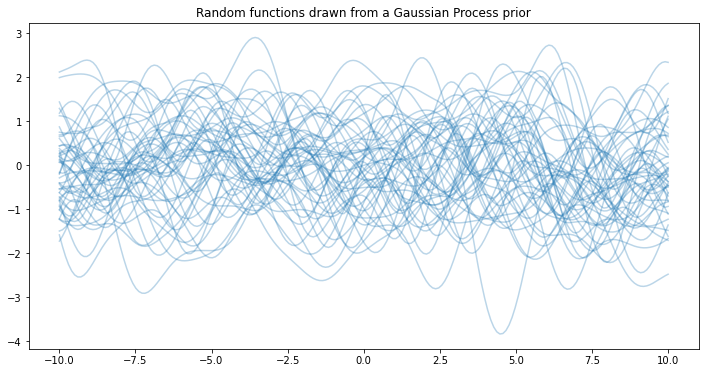

In [3]:
gp = GaussianProcessRegressor(RBF())
# gp = GaussianProcessRegressor(ExpSineSquared(periodicity=2*np.pi))
xs = np.linspace(-10, 10, 200)
sample_ys = gp.sample_y(xs.reshape((-1, 1)), n_samples=50, random_state=int(time.time()))
_ = plot_samples(xs, sample_ys)
plt.title("Random functions drawn from a Gaussian Process prior")

Now if context is added, the space of possible functions can be _conditioned_ on this context, which basically specifies that functions that are not conistent wth that context have zero probability. This is also called _fitting_ the GP to the example or context points. For instance we can sample some points from a sine function fit the GP to those, and then sample from the resulting _posterior_ distribution:

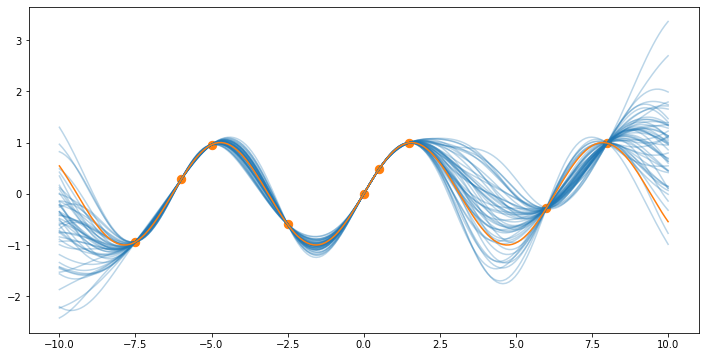

In [4]:
context_xs = np.array([-7.5, -6, -5, -2.5, 0, 0.5, 1.5, 6, 8])
context_ys = np.sin(context_xs)
gp.fit(context_xs.reshape(-1, 1), context_ys)
sample_ys = gp.sample_y(xs.reshape((-1, 1)), n_samples=50, random_state=int(time.time()))
plot_samples(xs, sample_ys)
plt.scatter(context_xs, context_ys, c=ccycle[1], s=70)
_ = plt.plot(xs, np.sin(xs), c=ccycle[1])

We see that all functions indeed go through these points, but there is still spread in between and past these points. This is commonly seen as a strenth of GPs: you get insight into the uncertaity about the actual function in areas where you don't have enough context, in contrast to other regression techniques that only give a single 'best fit' result.

As mentioned before, one can choose diferent kernels; actually the choise is infinite because kernels can be cmposited endlessly into more complex kernels. THis does allow one to inject prior the knowledge, like in this case that the function is periodic with period $2\pi$, by replacying the RBF kernel with an [Exp-Sine-Squared](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html) kernel with the appropriate arguments:

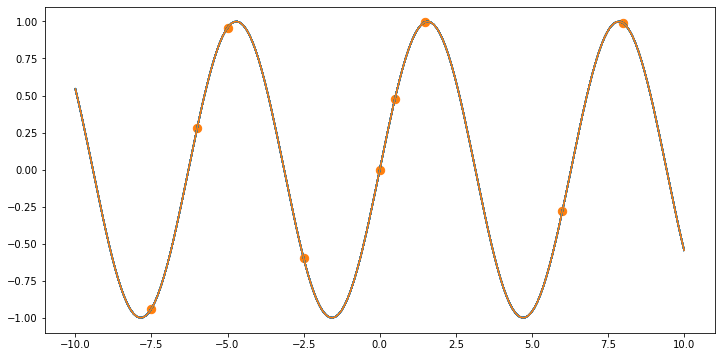

In [5]:
gp = GaussianProcessRegressor(ExpSineSquared(periodicity=2*np.pi))
gp.fit(context_xs.reshape(-1, 1), context_ys)
sample_ys = gp.sample_y(xs.reshape((-1, 1)), n_samples=50, random_state=int(time.time()))
plot_samples(xs, sample_ys)
plt.scatter(context_xs, context_ys, c=ccycle[1], s=70)
_ = plt.plot(xs, np.sin(xs), c=ccycle[1])

This gives a very different result, because the applied kernel restricts the space of functions to periodic ones, and there is only really one functio in that space that fits the given context. One problem now becomes to find the right kernel from the infinte possibilities.

### Learning Problem (GP)

* Find the best kernel and its parameters

   * Parameters optimized by maximum likelihood optimization
   * But: kernel combinations (multiply, sum) $\rightarrow$ infinite space
   * (Possibly elaborate) search needed (e.g. [Automatic Statistician](https://www.automaticstatistician.com/))

* GP complexity given $n$ context and $m$ targets: $O((n + m)^3)$

   * Besides difficulty of finding the right kernel, just fitting and evaluating a GP becomes unmanagable for large probles.

* **Solution: Neural Processes**

<center><img src="https://raw.githubusercontent.com/kasparmartens/NeuralProcesses/master/fig/schema1.png"></center>

<small>Source: <a href="https://kasparmartens.rbind.io/post/np/">https://kasparmartens.rbind.io/post/np/</a></small>

A neural process (NP) takes a set of context points, and maps those to a latent variable Z, the value of which should capture which function the data is generated by. Or, more accurately, paramaterize the posterior distribution that the function is drawn from.

This value is then combined with the target inputs, to get to the final target outputs.

<center><img src="https://raw.githubusercontent.com/kasparmartens/NeuralProcesses/master/fig/schema2.png"></center>

<small>Source: <a href="https://kasparmartens.rbind.io/post/np/">https://kasparmartens.rbind.io/post/np/</a></small>

In more detail, the mapping from context points to $Z$, and from ($Z$ + target input) to target output, is implemented as 2 neural networks: an encoder $h$, and a decoder $g$.

These are regular dense feedforward nets, and their hyperparameters---number and size of hidden layers, activation functions, and output dimensionality---determine the breadth of functions that the process can capture.

Each separate context point $x_c, y_c$ is fed through $h$ to derive a an encoded representation $r_c$. These individual representations are then aggregated into a single, overall representation $r$. The aggregation operation can be any that is immune to permutations; the original authors state that a simple average works well enough.

The encoding $r$ holds the paramters for the distribution of $Z$, which is taken to be normally distributed with a mean vector and deviation vector (or, the diagonal of the covariance matrix, i.e. dimensions of $Z$ are defined to be independent).

Finally, a single value is drawn from $Z$, which is appended to each of the target inputs, the result of which is fed through $g$ to arrive at the final predictions for each target. Because the same single value of $Z$ is appended to each $x_t$, the predictions are consistent, as in they are generated from the same function defined by $z$. By sampling multiple values of $z$, multiple predictions can be generated from a range of functions, indicating the uncertainty about which function is correct given the context points.

## Experiment 0: Drawing from prior
Mirorring the demonstrations with a GP above, we can start out with an NP that is not fit to any data yet, and use its decoder to generate prior samples of functions that the network can represent. We do this by drawing a number of samples (50) from $Z \sim \mathcal{N}(0, 10)$, appending them to $x \in [0, 100)$, and feed that through the randomly initialised decoder.

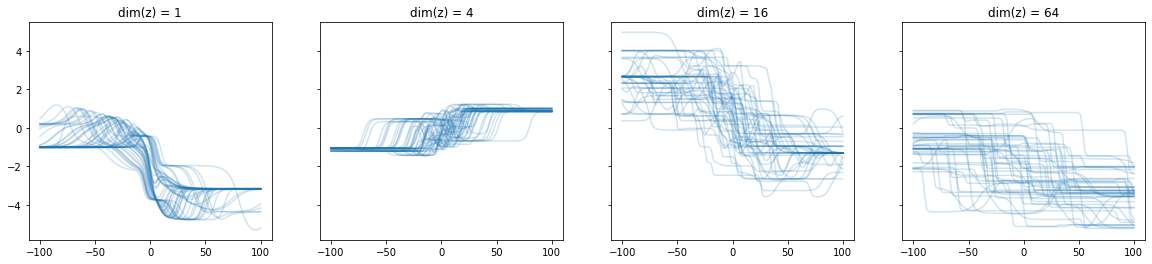

In [6]:
target_xs = np.linspace(-100, 100, 100, dtype=np.float32).reshape([-1, 1])
n_draws = 50

dim_z_values = [1, 4, 16, 64]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), sharey=True)

for dim_z_i, dim_z in enumerate(dim_z_values):
    # Create decoder, which will be randomly initialised
    params = NeuralProcessParams(
        dim_x=1,
        dim_y=1,
        n_hidden_units_h=[8],
        n_hidden_units_g=[8],
        dim_r=dim_z,
        dim_z=dim_z
    )

    decoder = network.Decoder(params)

    # Source of randomness
    epsilon = tf.random.normal([n_draws, params.dim_z], 0, 10)
    
    # Make predictions
    pred_ys = predict.prior_predict(
        target_xs,
        decoder,
        epsilon=epsilon,
        n_draws=tf.constant(n_draws)
    ).numpy()

    # Plot
    for i in range(n_draws):
        axes[dim_z_i].plot(target_xs, pred_ys[i], c=ccycle[0], alpha=0.2)
    axes[dim_z_i].set_title('dim(z) = {}'.format(params.dim_z))

We see that by increasing the dimensionality of the latent variable $Z$ the function space becomes more varied, due to the decoder's number of parameters increasing accordingly.

In [7]:
print(tf.__version__)

2.3.1


## Experiment 1: training on simple dataset
Next, we look at how an NP performs on the simplest task, where the space of functions that generate data consists of just a single sine function, of which we have 5 samples. In each training iteration a random amount of these samples is take as the context, with the rest serving as target samples of which the NP should predict the target outputs.

The goal of training the NP is to minimise the divergence $D_\mathrm{KL}(P || Q)$ between the real posterior distribution $p(y|context, x)$ and the approximation $q(y|context,x)$ that is formed by the neural process.

However, we don't have access to the real posterior. This is quite usual in this kind of variational inference settings, and the common approach is to refactor the divergence to arrive at a lower bound that does not depend on the posterior, and when maximized guarantees the minimisation of the goal divergence; the so called _evidence_ lower bound, or ELBO:

$$
\log 𝑝(𝑦_t^{\ast} | \text{𝑐𝑜𝑛𝑡𝑒𝑥𝑡},𝑥_t^{\ast}) \geq \text {ELBO} = \mathbb{E}_{q(z | \text {context}, \text {target})} \left[ \sum_{t=1}^T \log p(y_t^{\ast} | z, x_t^{\ast}) + \log \frac{q(z | \text {context})}{q(z | \text {context}, \text {target})} \right]
$$

The ELBO here turns out to consist of 2 terms: the log-likelihood of $z$ given the target samples, and the divergence between the distribution of the latent variable given just the context or given both the context and the target samples. The first rewards when targets are predicted with high probability given the latent variable and the target inputs, encouraging the encoder to provide a good encoding and the decoder to better map those to functions in tandem. The second term is the divergence of $z$ given just the context and given both the context and target samples, which helps enforce consistency, since the context and targets are drawn from the same function, so they should encode to similar latent distributions.

For the experiment we start with a dataset that generates a series of random splits of 5 samples of a simple sine function:

In [8]:
n_samples = 5

xs = np.linspace(-2, 2, n_samples).reshape([-1, 1]).astype(np.float32)
ys = np.sin(xs).astype(np.float32)

def data_generator(n_iter):
    for _ in range(n_iter):
        n_context = random.choice(range(1, n_samples))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)
        yield context_xs, context_ys, target_xs, target_ys
        
ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.float32, tf.float32, tf.float32, tf.float32), args=(100,))

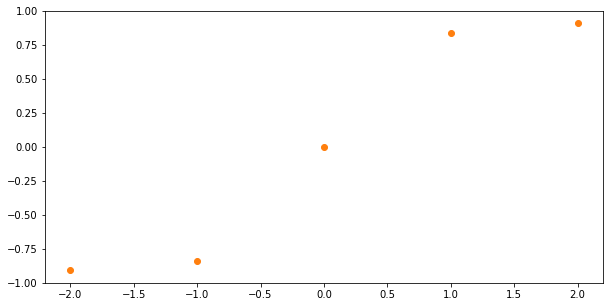

In [9]:
# Plot the samples, setting up plot elements
fig, ax = plt.subplots(figsize=(10,5))
lns = [(plt.plot([], [], c=ccycle[0], alpha=0.05, animated=True))[0] for _ in range(n_draws)]
target_sct = plt.scatter(xs, ys, c=ccycle[1])

Next, we will train the neural process by iterating through the samples for 20 epochs and determining the ELBO based loss as described above.

In [10]:
from neuralprocesses.train import train_step

# Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=2,
    dim_z=2,
    n_hidden_units_h=[8, 8, 8],
    n_hidden_units_g=[8, 8, 8]
)

neurproc = process.NeuralProcess(params)

# Train settings
n_epochs = 20
n_iter = 100
n_train_draws = 7
n_test_draws = 200

test_xs = np.linspace(-10, 10, 100).reshape([-1, 1])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_loss = tf.keras.metrics.Mean(name='train_loss')

# Do training
all_pred_ys = []
for e in tqdm(range(n_epochs), desc="Training epochs"):
    train_loss.reset_states()

    for context_xs, context_ys, target_xs, target_ys in ds:
        loss = train_step(
            neurproc, 
            optimizer, 
            context_xs, 
            context_ys, 
            target_xs, 
            target_ys, 
            n_train_draws
        )
        train_loss(loss)
    
    # Make predictions with all known points as context
    pred_ys_mu, c_mu, c_sigma = neurproc([xs], [ys], [test_xs], n_draws=n_test_draws)
    all_pred_ys.append(tf.squeeze(pred_ys_mu))
    print(f"Loss: {train_loss.result()}")


Loss: 15.122491836547852
Loss: 10.417708396911621
Loss: 8.422830581665039
Loss: 4.428951263427734
Loss: 0.8032005429267883
Loss: -0.8062586188316345
Loss: -1.023705005645752
Loss: -1.078062891960144
Loss: -1.1050877571105957
Loss: -1.1254459619522095
Loss: -1.1917142868041992
Loss: -1.1770507097244263
Loss: -1.1510875225067139
Loss: -1.120410442352295
Loss: -1.1721975803375244
Loss: -1.1090552806854248
Loss: -1.1287232637405396
Loss: -1.1435424089431763
Loss: -1.1442327499389648
Loss: -1.0898544788360596



We have recorded the predictions given by the neural process at the end of the epoch given all 5 samples as context, which are put together in the following animation, showing that the NP passes this simple test of learning a family of functions of size 1:

In [11]:
def init_animation():
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-2, 2)
    return lns

def update_animation(frame):
    for i in range(n_draws):
        lns[i].set_data(test_xs.flatten(), frame.numpy()[i])
    return lns

anim = animation.FuncAnimation(fig, update_animation, frames=all_pred_ys, init_func=init_animation, blit=True)
HTML(anim.to_jshtml())

## Experiment 2: training on a class of functions
In this next experiment we will look at the scenario that neural processes are designed for: observed samples can be generated by any function from a family of functions of possibly infinite size. In this case this is the family of sinusoidal functions with a fixed period of $2\pi$, but a variable amplitude.

To generate the train data, at each iteration we sample an amplitude uniformly $a \sim \mathcal{U}(-2, 2)$ take 20 samples of the function $a \cdot \text{sin}(\frac{1}{2\pi}x)$, of which we randomly take up to 10 samples as context, and the rest as train targets.

In [56]:
def data_generator(n_iter):
    for i in range(n_iter):
        # Select 20 random observations from a sinoid with a random amplitude
        n_obs = 20
        xs = np.random.uniform(-3, 3, n_obs).reshape([-1, 1]).astype(np.float32)
        amp = random.uniform(-2, 2)
        ys = (amp * np.sin(xs)).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)
        yield context_xs, context_ys, target_xs, target_ys
        
ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.float32, tf.float32, tf.float32, tf.float32), args=(100,))

In [58]:
print(ds)

<FlatMapDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.float32)>


In [13]:
from neuralprocesses.loss import loglikelihood, kullback_leibler_gaussian

In [14]:
# Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=2,
    dim_z=2,
    n_hidden_units_h=[8, 8, 8],
    n_hidden_units_g=[8, 8, 8]
)

neurproc = process.NeuralProcess(params)

# Strain settings
n_epochs = 500
n_iter = 100
n_train_draws = 7
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_loss = tf.keras.metrics.Mean(name='train_loss')

for e in tqdm(range(n_epochs), desc="Training epochs"):
    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a sinoid with a random amplitude
        n_obs = 20
        xs = np.random.uniform(-3, 3, n_obs).reshape([-1, 1]).astype(np.float32)
        amp = random.uniform(-2, 2)
        ys = (amp * np.sin(xs)).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")

Loss: 148.79690551757812
Loss: 93.22148132324219
Loss: 67.4563980102539
Loss: 78.01153564453125
Loss: 84.82213592529297
Loss: 76.8028793334961
Loss: 78.365966796875
Loss: 68.31739044189453
Loss: 65.70182800292969
Loss: 80.18679809570312
Loss: 70.18041229248047
Loss: 75.09294128417969
Loss: 70.32872009277344
Loss: 62.76328659057617
Loss: 76.14048767089844
Loss: 86.8112564086914
Loss: 92.40223693847656
Loss: 77.5652847290039
Loss: 78.587890625
Loss: 77.74718475341797
Loss: 76.3416519165039
Loss: 62.022621154785156
Loss: 72.42713928222656
Loss: 77.5558853149414
Loss: 72.68460083007812
Loss: 65.38374328613281
Loss: 67.7004165649414
Loss: 77.98206329345703
Loss: 93.26092529296875
Loss: 67.059326171875
Loss: 83.22332000732422
Loss: 85.07972717285156
Loss: 73.56031036376953
Loss: 70.77271270751953
Loss: 78.06143188476562
Loss: 68.3414077758789
Loss: 68.0618667602539
Loss: 70.66419982910156
Loss: 70.40206146240234
Loss: 69.99656677246094
Loss: 59.703521728515625
Loss: 60.77360916137695
Loss: 5

Because we have chosen a 2-dimensional latent variable, we can nicely visualise the types of functions that different values of $Z$ produce, by prefixing them and do a forward pass through the decoder for a range of inputs.

In [15]:
import itertools

input_xs = np.linspace(-4, 4, 100).reshape([-1, 1])
z1s = np.arange(-4, 5)
z2s = np.arange(-4, 5)

# Pass in fixed latent values for the source of 'randomness'
eps_value = np.asarray(list(itertools.product(z1s, z2s)))
eps = tf.constant(eps_value, dtype=tf.float32)

pred_ys = predict.prior_predict(input_xs, neurproc.decoder, eps).numpy()
pred_ys = pred_ys.reshape([len(z1s), len(z2s), len(input_xs)])

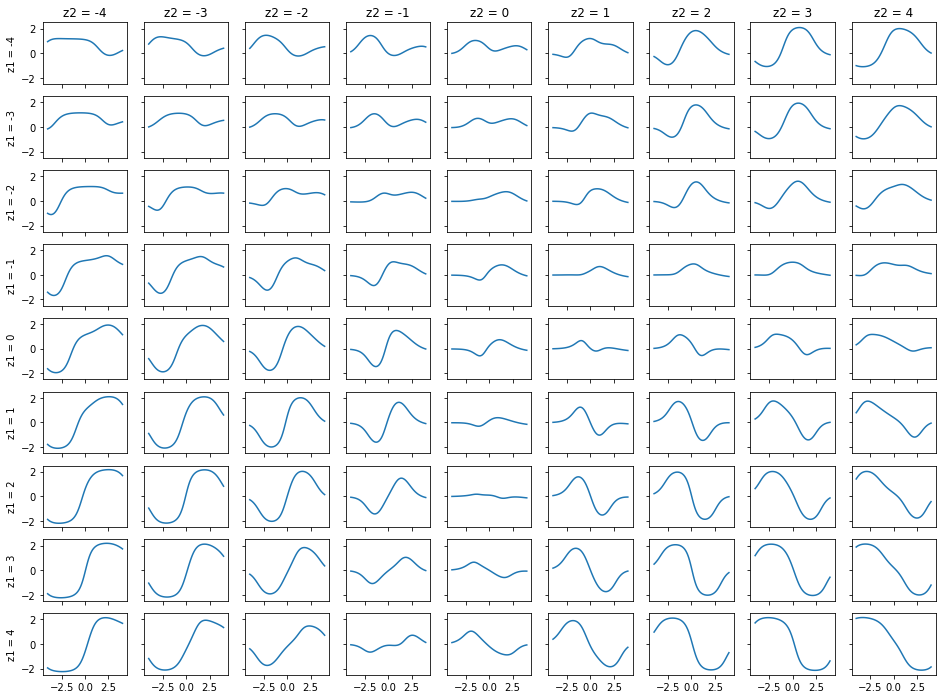

In [16]:
fig, axes = plt.subplots(len(z1s), len(z2s), sharex=True, sharey=True, figsize=(16, 12))

for i in range(len(z1s)):
    for j in range(len(z2s)):
        ax = axes[i][j]
        if i == 0:
            ax.set_title("z2 = {}".format(z2s[j]))
        if j == 0:
            ax.set_ylabel("z1 = {}".format(z1s[i]))
        
        ax.set_xlim((-4.5, 4.5))
        ax.set_ylim((-2.5, 2.5))
        ax.plot(input_xs, pred_ys[i, j])

If training was successful, the graphs will show a gradual shift from functions with high to low amplitude when one or both of the latent values increases or decreases. This shows that the latent variable can be seen as mapping the space of functions into a lower dimensional space, in a smooth and continuous way.

Finally, the whole idea of Neural Processes is that it allows to make a prediction in terms of a distribution over likely functions given a number of context points. The following bit will take a number of random inputs $x_c \in [-3, 3]$ and the corresponsing output given a sine function with amplitude 1, feed them through as the context values, and then evaluate the output of the NP over the range $x_t \in [-4, 4]$.

rs tf.Tensor([1 2 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 3 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 4 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 5 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 6 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 7 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 8 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 9 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)
rs tf.Tensor([1 9 2], shape=(3,), dtype=int32)
aggregate_r tf.Tensor([1 2], shape=(2,), dtype=int32)


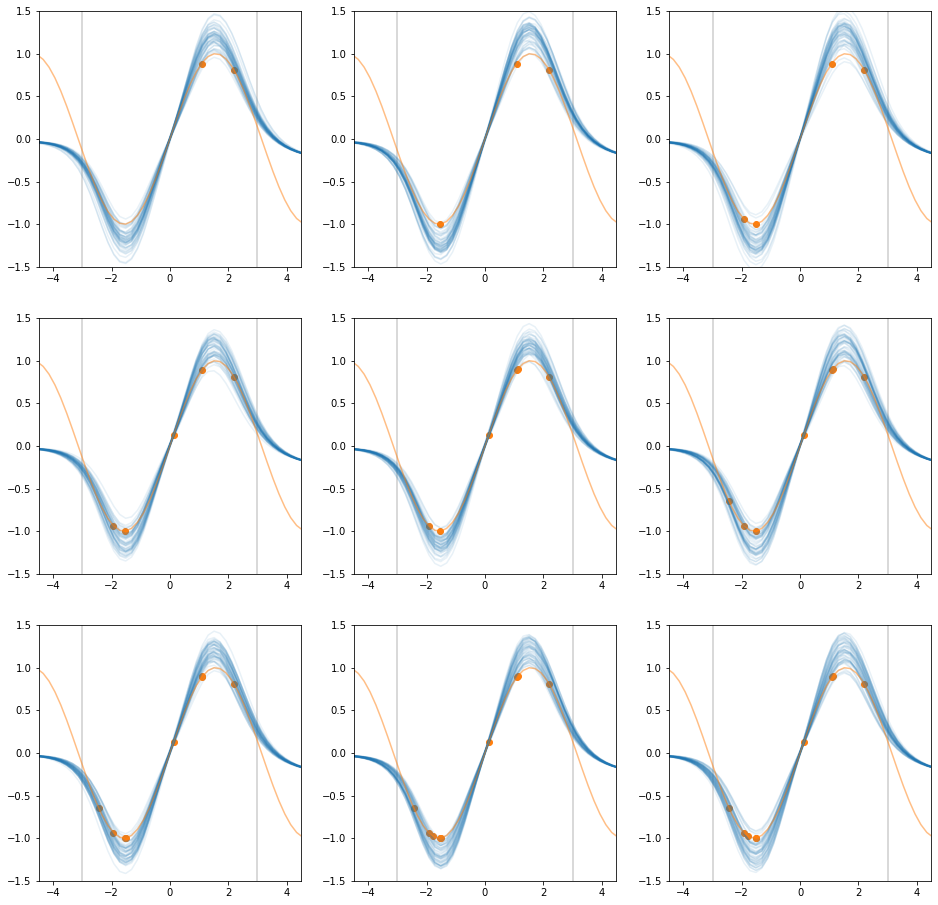

In [55]:
def plot_prediction(ax, context_xs, context_ys):
    input_xs= np.linspace(-10, 10, 100)
    pred_ys, z_mu, z_sigma = neurproc(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=50
    )
    pred_ys = tf.squeeze(pred_ys).numpy()
    
    for i in range(pred_ys.shape[0]):
        ax.plot(input_xs, pred_ys[i], c=ccycle[0], alpha=0.1)
    ax.plot(input_xs, np.sin(input_xs), c=ccycle[1], alpha=.5)
    ax.scatter(context_xs, context_ys, c=ccycle[1])
    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-1.5, 1.5))
    ax.vlines(-3, -1.5, 1.5, alpha=.2)
    ax.vlines(3, -1.5, 1.5, alpha=.2)

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
all_context_xs = np.random.uniform(-3, 3, max_n_context)

for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context+1]
    context_ys = np.sin(context_xs)
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys)


We see that the NP shows some similarity to Gaussian Processes, however with some important distinctions:

* The NP does not necessarily output functions that exactly fit the context points. The information of their exact location is lost when passed through the network, however it is obvious that the actual shape of the function that they suggest is indeed predicted by the network. The authors improve on this in an[extension of this work that uses an attention mechanism to recover this focus](https://arxiv.org/abs/1901.05761).
* Where a GP normally fans out past the context points, the NP converges to a tight distribution close to $y=0$. This is at least partly due to a limitation of this implementation, where the decoder currently only predicts a mean, without a covariance, so the fact that the uncertainty around that mean is high away from the context points is lost.

# Further examples
The original paper shows more interesting applications of NPs, not yet implemented here, with firstly recovering MNIST digits from only some context points in the form of pixel values at random locations:

<center><img src="digits.png" width="50%"></center>

And secondly, a similar application of generating faces in from a subset of pixels:

<center><img src="faces.png" width="50%"></center>

In [47]:
x = [[1, 2, 3, 5], [4, 6, 7, 8]]
y = [[2, 4, 6, 10], [8, 12, 14, 16]]

x = tf.reshape(x, [2, 4])
y = tf.reshape(y, [2, 4])

In [48]:
context_xys = tf.concat([x, y], axis = -1)
print(context_xys)

tf.Tensor(
[[ 1  2  3  5  2  4  6 10]
 [ 4  6  7  8  8 12 14 16]], shape=(2, 8), dtype=int32)


In [49]:
n_c = tf.shape(context_xys)[-2]
print(n_c)

tf.Tensor(2, shape=(), dtype=int32)


In [52]:
batch_size = tf.shape(context_xys)[0]
print(batch_size)

tf.Tensor(2, shape=(), dtype=int32)
